In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.ma.core import not_equal

from MLP import MLPRegressor
from Problems import DTLZ2

## DTLZ2 Problem

## Problem Class

In [23]:
class FunctionalProblem:
    def __init__(self, n_var=1, objs=list, lb=0., ub=1.):
        self.n_var = n_var
        self.objs = objs
        self.n_dim = len(objs)
        self.lb = lb
        self.ub = ub

    def evaluate(self, X):
        """
        Evaluate the objective functions for a given population.

        :param X:
        :return:
        """

        F = np.zeros((X.shape[0], len(self.objs)))
        for i, x in enumerate(X):
            for j, obj in enumerate(self.objs):
                F[i][j] = obj(x)

        return F


## Individual Class

In [24]:
class Individual:
    def __init__(self):
        self.X = None
        self.F = None
        self.CD = None
        self.front = None
        self.crowding_distance = 0.0

    def reset_crowding_distance(self):
        self.crowding_distance = 0.0

    def reset_front(self):
        self.front = 0

    def setX(self, X):
        self.X = X

    def setF(self, F):
        self.F = F

    def getX(self):
        return self.X

    def getF(self):
        return self.F


## Population Class

In [25]:
class Population:
    def __init__(self, pop_size=100):
        self.pop_size = pop_size
        self.pop = np.array([Individual() for _ in range(pop_size)])

    def initialise_population(self, problem):
        X = np.random.uniform(problem.lb, problem.ub, (self.pop_size, problem.n_var))
        for i, ind in enumerate(self.pop):
            ind.setX(X[i])


    def set_population(self, inds: [Individual]):
        assert len(inds) == self.pop_size
        self.pop = inds

    def set_decision_vectors(self, X):
        assert len(X) == self.pop_size

        for i, ind in enumerate(self.pop):
            ind.setX(X[i])

    def set_objectives(self, F):
        assert len(F) == self.pop_size
        for i, ind in enumerate(self.pop):
            ind.setF(F[i])


    def get(self, var):
        if var == "X":
            return np.array([ind.getX() for ind in self.pop])
        elif var == "F":
            return np.array([ind.getF() for ind in self.pop])
        else:
            raise ValueError("Invalid variable name.")

    def crowding_distance(self, front):
        """
        Calculate the crowding distance for a front of individuals.
        """

        if len(front) == 0:
            return

        num_objectives = len(front[0].F)

        for ind in front:
            ind.reset_crowding_distance()

        for m in range(num_objectives):
            # Sort them by their objective vector values
            front.sort(key=lambda ind: ind.F[m])

            # Extreme values have infinite crowding distance
            front[0].crowding_distance = front[-1].crowding_distance = float('inf')

            min_f = front[0].F[m]
            max_f = front[-1].F[m]

            if max_f == min_f:
                continue

            for i in range(1, len(front) - 1):
                front[i].crowding_distance += (front[i + 1].F[m] - front[i - 1].F[m]) / (max_f - min_f)


    def non_dominated_sort(self):
        """
        Perform non-dominated sorting on the population.
        :return: List of fronts, where each front is a list of Individuals.
        """
        def ndf(population):
            points = np.array([ind.F for ind in population])
            A = points[:, np.newaxis, :]
            B = points[np.newaxis, :, :]

            better_or_equal = np.all(B <= A, axis=2)
            strictly_better = np.any(B < A, axis=2)
            dominated = better_or_equal & strictly_better
            np.fill_diagonal(dominated, False)

            return ~np.any(dominated, axis=1)

        for ind in self.pop:
            ind.reset_front()

        fronts = []
        data = self.pop.copy()
        front_number = 0

        while len(data) > 0:
            f = ndf(data)
            front = [data[i] for i in range(len(data)) if f[i]]
            fronts.append(front)
            data = [data[i] for i in range(len(data)) if not f[i]]

            for ind in front:
                ind.front = front_number
            front_number += 1

        return fronts

    def crowded_tournament_selection(self):
        """
        Perform crowded tournament selection to select parents for crossover.

        :return: Selected parents
        """
        fronts = self.non_dominated_sort()
        for front in fronts:
            self.crowding_distance(front)

        selected = []
        while len(selected) < self.pop_size:
            individuals = np.random.choice(self.pop, 2, replace=True)


            if individuals[0].front < individuals[1].front:
                selected.append(individuals[0])
            elif individuals[0].front > individuals[1].front:
                selected.append(individuals[1])
            else:
                if individuals[0].crowding_distance > individuals[1].crowding_distance:
                    selected.append(individuals[0])
                else:
                    selected.append(individuals[1])

        return selected


    def merge(self, other):
        """
        Merge two populations.
        """
        self.pop = np.concatenate([self.pop, other.pop])
        self.pop_size = len(self.pop)

        return self



## Genetic Operators
- #### Simulated Binary Crossover (SBX)
- #### Polynomial Mutation



In [26]:
def sbx_crossover(parents, eta_c=2, crossover_prob=0.9, lb=0., ub=1.):
    """
    Perform Simulated Binary Crossover (SBX) on a given parent population.

    Args:
        parents np.ndarray: Parent population of shape (N, D), where N is the number of parents,
                                 and D is the number of genes per individual.
        eta_c (float): Distribution index that controls the spread of offspring.
        crossover_prob (float): Probability of performing crossover.

    Returns:
        numpy.ndarray: Offspring population of the same shape as parents.
    """

    """if parents.shape == (parents.shape[0], ):
        parents = np.reshape(parents, (parents.shape[0], 1))"""

    if parents.ndim == 1:
        parents = parents.reshape(-1, 1)


    num_parents, num_genes = parents.shape
    offspring = np.copy(parents)

    for i in range(0, num_parents - 1, 2):  # Pairwise crossover
        if np.random.rand() < crossover_prob:
            p1, p2 = parents[i], parents[i + 1]
            c1, c2 = np.copy(p1), np.copy(p2)


            for j in range(num_genes):
                u = np.random.rand()
                if u < 0.5:
                    beta_q = np.power((2 * u), (1 / (eta_c + 1)))
                else:
                    beta_q = np.power((1 / (2 * (1 - u))), (1 / (eta_c + 1)))

                c1[j] = (0.5 * (1 + beta_q) * p1[j] + (1 - beta_q) * p2[j])
                c2[j] = (0.5 * (1 - beta_q) * p1[j] + (1 + beta_q) * p2[j])

                c1 = np.clip(c1, lb, ub)
                c2 = np.clip(c2, lb, ub)

            offspring[i], offspring[i + 1] = c1, c2

    return offspring


def polynomial_mutation(X, prob, eta, xl, xu):
    """
    Perform polynomial mutation on a given population.

    Args:
        X np.ndarray: Population of shape (N, D), where N is the number of individuals,
                      and D is the number of genes per individual.
        prob (float): Mutation rate.
        eta (int): Mutation distribution index.
        xl (float): Lower bound of the gene.
        xu (float): Upper bound of the gene.

    Returns:
        np.ndarray: Mutated population of the same shape as X.
    """

    xl = np.array([xl for _ in range (X.shape[1])])
    xu = np.array([xu for _ in range (X.shape[1])])

    mut = np.random.rand(X.shape[0]) < prob
    _X = np.copy(X)

    for i, x in enumerate(X):
        if mut[i]:
            delta_1 = (x - xl) / (xu - xl)
            delta_2 = (xu - x) / (xu - xl)

            r = np.random.rand(1)
            if r <= 0.5:
                dq1 = (2. * r) + ( (1. - (2 * r)) * np.power((1 - delta_1), (eta + 1)))

                delta_q = (np.power(dq1, 1 / (eta + 1))) - 1
                #delta_q = (2 * r + (1 - 2 * r) * (1 - delta_1) ** (eta + 1)) ** (1 / eta + 1) - 1
            else:

                dq1 = (2. * (1. - r)) + ((2. * (r - 0.5)) *  np.power((1. - delta_2), (eta + 1)))
                delta_q = 1 - np.power(dq1, 1 / (eta + 1))

                #delta_q = 1 - (2 * (1 - r) + 2 * (r - 0.5) * (1 - delta_2) ** eta + 1) ** (1 / (eta + 1))

            x_mutated = x + (delta_q * (xu - xl))

            x_mutated = np.clip(x_mutated, xl, xu)

            _X[i] = x_mutated

    return _X

def genetic_opertation(parents, eta_c=20, crossover_prob=0.9, mutation_rate=0.2, eta_m=20, lb=0., ub=1.):
    """
    Perform genetic operations (crossover and mutation) on a given parent population.

    Args:
        parents Population: Parent population
        eta_c (float): Distribution index that controls the spread of offspring.
        crossover_prob (float): Probability of performing crossover.
        mutation_rate (float): Probability of mutating a gene.
        eta_m (int): Mutation distribution index.
        lb (float): Lower bound of the gene.
        ub (float): Upper bound of the gene.

    Returns:
        numpy.ndarray: Offspring population of the same shape as parents.
    """

    parents = parents.get("X")

    crossover_offspring = sbx_crossover(parents, eta_c, crossover_prob, lb, ub)

    mutated_offspring = np.array(polynomial_mutation(crossover_offspring, mutation_rate, eta_m, lb, ub))

    offspring = Population(pop_size=len(parents))
    offspring.set_decision_vectors(mutated_offspring)

    return offspring

## Elitism Selection

In [27]:
def elitism(parents: Population, offspring: Population):
    """
    Perform elitism selection to select the next generation.

    Args:
        parents Population: Parent population of shape (N, D), where N is the number of parents,
                                 and D is the number of genes per individual.
        offspring Population: Evaluated Offspring population of the same shape as parents.

    Returns:
        next_generation Population: Next generation population.
    """

    combined_population = parents.merge(offspring)
    fronts = combined_population.non_dominated_sort()

    next_generation = []

    for f in fronts:
        if len(next_generation) + len(f) > offspring.pop_size:
            combined_population.crowding_distance(f)

            f.sort(key=lambda ind: ind.crowding_distance, reverse=True)

            next_generation.extend(f[:offspring.pop_size - len(next_generation)])
        else:
            next_generation.extend(f)

    next_gen = Population(pop_size=offspring.pop_size)
    next_gen.set_population(next_generation)

    return next_gen

In [28]:
def run(n_gen, pop_size, problem):
    pop = Population(pop_size=pop_size)
    pop.initialise_population(problem)
    pop.set_objectives(problem.evaluate(pop.get("X")))

    for gen in range(n_gen):

        # Perform crowded tournament selection to select parents
        parents = Population(pop_size=pop_size)
        parents.set_population(pop.crowded_tournament_selection())

        # Perform Crossover and mutation to generate offspring
        offspring = genetic_opertation(parents, lb=problem.lb, ub=problem.ub)

        # Evaluate the offspring
        offspring.set_objectives(problem.evaluate(offspring.get("X")))

        # Use Non-dominated sorting and crowded distance to select the next generation
        pop = elitism(parents, offspring)

        print(f"Generation {gen} completed.")

    return pop

def run_surrogate(n_gen, pop_size, problem, mlp, FE_max, R, epsilon):

    MAE = []

    X = np.random.randn(FE_max, problem.n_var)
    y = problem.evaluate(X)
    mlp.fit(X, y)

    predicted = mlp.predict(X)
    print(f"Initial MAE: {np.mean(np.abs(y - predicted))}")
    print(predicted[:5])

    gen = 0
    new_samples = []

    pop = Population(pop_size=pop_size)
    pop.initialise_population(problem)
    pop.set_objectives(mlp.predict(pop.get("X")))

    while gen < n_gen:
        # Perform crowded tournament selection to select parents
        parents = Population(pop_size=pop_size)
        parents.set_population(pop.crowded_tournament_selection())

        # Perform Crossover and mutation to generate offspring
        offspring = genetic_opertation(parents, lb=problem.lb, ub=problem.ub)

        # Evaluate the offspring
        if gen % R == 0:
            Xs = offspring.get("X")
            print(f"X : {len(Xs)}")
            true_objectives = problem.evaluate(Xs)
            predicted_objectives = mlp.predict(Xs)
            offspring.set_objectives(true_objectives)

            MAE.append(np.mean(np.abs(predicted_objectives - true_objectives)))

            index = np.random.randint(0, len(Xs))
            print(f"Xs : {Xs[index]} - {true_objectives[index]} : {predicted_objectives[index]} : Error : {np.mean(np.abs(true_objectives[index] - predicted_objectives[index]))}")

            for i in range(len(Xs)):
                error = np.mean(np.abs(true_objectives[i] - predicted_objectives[i]))

                # If error exceeds threshold, add the point to retraining data
                if error > epsilon:
                    new_samples.append((Xs[i], true_objectives[i]))

            if new_samples:

                X_new, Y_new = [i[0] for i in new_samples], [i[1] for i in new_samples]
                print(f"Retraining with {len(new_samples)} new samples.")
                X = np.vstack((X, np.array(X_new)))
                y = np.vstack((y, np.array(Y_new)))


                if X.shape[0] > 2000:
                    X = X[-2000:]
                    y = y[-2000:]

                print(X.shape, y.shape)

                mlp.fit(X, y)
                new_samples.clear()

        else:
            offspring.set_objectives(mlp.predict(offspring.get("X")))

        # Use Non-dominated sorting and crowded distance to select the next generation
        pop = elitism(parents, offspring)

        gen+=1

        print(f"Generation {gen} completed.")
    return pop, MAE


In [29]:
from sklearn.model_selection import train_test_split

n_var = 2
n_obj = 2

mlp = MLPRegressor([n_var, 5, n_obj], learning_rate=0.01, epochs=1000)

objs = [
    lambda x: np.sum((x + 2) ** 2),
    lambda x: np.sum((x - 2) ** 2)
]
lb, ub = -2, 2

#problem = DTLZ2(n_var=n_var, n_obj=n_obj)

problem = FunctionalProblem(n_var=n_var, objs=objs, lb=lb, ub=ub)


In [30]:

pop = run(10, 100, problem)
#pop, mae = run_surrogate(11, 100, problem, mlp, 200, 5, 0.1)
F = np.array(pop.get("F"))

Generation 0 completed.
Generation 1 completed.
Generation 2 completed.
Generation 3 completed.
Generation 4 completed.
Generation 5 completed.
Generation 6 completed.
Generation 7 completed.
Generation 8 completed.
Generation 9 completed.


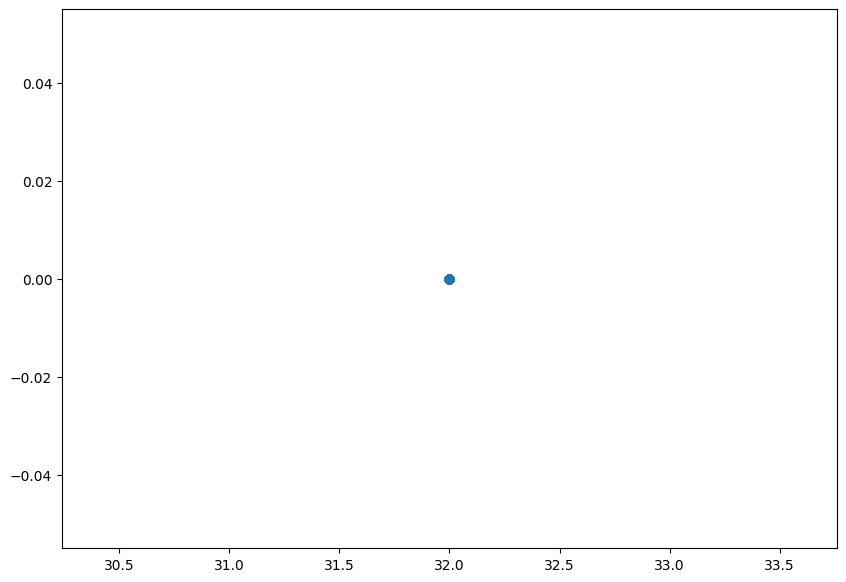

100


'plt.plot(mlp.loss)\nplt.title("MSE")\nplt.xlabel("MLP Loss")\nplt.ylabel("MSE")\nplt.show()\n\nplt.plot(mae)\nplt.title("MLP vs True Objectives MAE")\nplt.xlabel("Number of generations / R")\nplt.ylabel("MAE")\nplt.show()'

In [31]:

fig = plt.figure(figsize=(10, 7))
#ax = fig.add_subplot(projection="3d")
plt.scatter(F[:, 0], F[:, 1])#, F[:, 2])
plt.show()
print(len(F))

"""plt.plot(mlp.loss)
plt.title("MSE")
plt.xlabel("MLP Loss")
plt.ylabel("MSE")
plt.show()

plt.plot(mae)
plt.title("MLP vs True Objectives MAE")
plt.xlabel("Number of generations / R")
plt.ylabel("MAE")
plt.show()"""